In [1]:
import tarfile
import os

# Define your dataset directory
data_dir = 'O:/Fellowship AI/Flower-Dataset/data'

# Extract the flower images
with tarfile.open(os.path.join(data_dir, '102flowers.tgz'), 'r:gz') as tar:
    tar.extractall(path=data_dir)

# Extract the segmentations
with tarfile.open(os.path.join(data_dir, '102segmentations.tgz'), 'r:gz') as tar:
    tar.extractall(path=data_dir)


In [2]:
import scipy.io

# Load the labels and set ids
labels_path = os.path.join(data_dir, 'imagelabels.mat')
labels_data = scipy.io.loadmat(labels_path)
image_labels = labels_data['labels'][0]  # Extract labels (1D array)

setid_path = os.path.join(data_dir, 'setid.mat')
setid_data = scipy.io.loadmat(setid_path)
train_ids = setid_data['trnid'][0]  # Training set ids
val_ids = setid_data['valid'][0]    # Validation set ids
test_ids = setid_data['tstid'][0]   # Test set ids


In [3]:
from PIL import Image

def load_image(img_id):
    image_path = os.path.join(data_dir, 'jpg', f'image_{img_id:05d}.jpg')
    return Image.open(image_path)


sample_image = load_image(train_ids[0])
sample_image.show()  # Visualize one of the training images


In [4]:
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms

class FlowerDataset(Dataset):
    def __init__(self, image_ids, labels, data_dir, transform=None):
        self.image_ids = image_ids
        self.labels = labels
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        image = load_image(img_id)
        label = self.labels[img_id - 1] - 1  # Convert labels to 0-indexed

        if self.transform:
            image = self.transform(image)

        return image, label

# Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Instantiate the dataset
train_dataset = FlowerDataset(train_ids, image_labels, data_dir, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)


In [5]:
import torch.nn as nn
from torchvision import models

# Load a pre-trained ResNet18 model
model = models.resnet18(pretrained=True)
num_features = model.fc.in_features

# Replace the final fully connected layer with a new one for 102 classes
model.fc = nn.Linear(num_features, 102)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


C:\Users\tonyg\anaconda3\envs\dsc-shared\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\tonyg\anaconda3\envs\dsc-shared\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\tonyg/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:26<00:00, 1.77MB/s]


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Training loop
for epoch in range(10):  # Number of epochs
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device).long()  # Convert labels to long type

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")


Epoch 1, Loss: 3.5377321615815163
Epoch 2, Loss: 1.2756916340440512
Epoch 3, Loss: 0.40740557573735714
Epoch 4, Loss: 0.12548331799916923
Epoch 5, Loss: 0.053726274927612394
Epoch 6, Loss: 0.016915938540478237
Epoch 7, Loss: 0.009721837399411015
Epoch 8, Loss: 0.004943317406286951
Epoch 9, Loss: 0.0035966787472716533
Epoch 10, Loss: 0.0030246961941884365


In [8]:
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [10]:
import torchvision.transforms as transforms

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to the required input size
    transforms.ToTensor(),          # Convert image to PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalization
])


In [11]:
from torch.utils.data import Dataset
from PIL import Image
import os
import scipy.io

class FlowerDataset(Dataset):
    def __init__(self, image_ids, labels, data_dir, transform=None):
        self.image_ids = image_ids
        self.labels = labels
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        image_path = os.path.join(self.data_dir, 'jpg', f'image_{img_id:05d}.jpg')
        image = Image.open(image_path).convert('RGB')
        label = self.labels[img_id - 1] - 1  # Convert labels to 0-indexed

        if self.transform:
            image = self.transform(image)

        return image, label


In [12]:
import scipy.io

data_dir = 'data/'  # Assuming your dataset files are located in this directory

# Load labels from imagelabels.mat
labels_path = os.path.join(data_dir, 'imagelabels.mat')
labels_data = scipy.io.loadmat(labels_path)
image_labels = labels_data['labels'][0]

# Load test set IDs from setid.mat
setid_path = os.path.join(data_dir, 'setid.mat')
setid_data = scipy.io.loadmat(setid_path)
test_ids = setid_data['tstid'][0]


In [13]:
test_dataset = FlowerDataset(image_ids=test_ids, labels=image_labels, data_dir=data_dir, transform=test_transform)


In [14]:
from torch.utils.data import DataLoader

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [15]:
import torch

correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Test Accuracy: {accuracy:.2f}%')


Test Accuracy: 83.66%


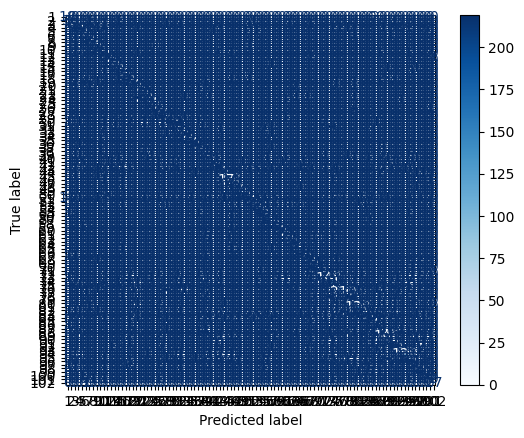

In [16]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(1, 103))
disp.plot(cmap=plt.cm.Blues)
plt.show()


In [17]:
from sklearn.metrics import classification_report

# Generate classification report
print(classification_report(y_true, y_pred, target_names=[f'Class {i}' for i in range(1, 103)]))


              precision    recall  f1-score   support

     Class 1       0.49      0.90      0.63        20
     Class 2       1.00      0.90      0.95        40
     Class 3       0.27      0.45      0.34        20
     Class 4       0.30      0.39      0.34        36
     Class 5       0.85      0.89      0.87        45
     Class 6       0.85      0.92      0.88        25
     Class 7       0.86      0.95      0.90        20
     Class 8       0.98      1.00      0.99        65
     Class 9       0.69      0.85      0.76        26
    Class 10       0.93      1.00      0.96        25
    Class 11       0.46      0.76      0.57        67
    Class 12       0.94      0.97      0.96        67
    Class 13       0.94      1.00      0.97        29
    Class 14       0.84      0.96      0.90        28
    Class 15       0.82      0.93      0.87        29
    Class 16       0.44      0.90      0.59        21
    Class 17       0.98      0.88      0.93        65
    Class 18       0.79    

In [18]:
def top_k_accuracy(model, dataloader, k=5):
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, top_k_predictions = outputs.topk(k, 1, True, True)
            top_k_predictions = top_k_predictions.t()
            correct += top_k_predictions.eq(labels.view(1, -1).expand_as(top_k_predictions)).sum().item()
            total += labels.size(0)

    return correct / total

top_k_acc = top_k_accuracy(model, test_loader, k=5)
print(f'Top-5 Accuracy: {top_k_acc * 100:.2f}%')


Top-5 Accuracy: 95.22%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.622571].


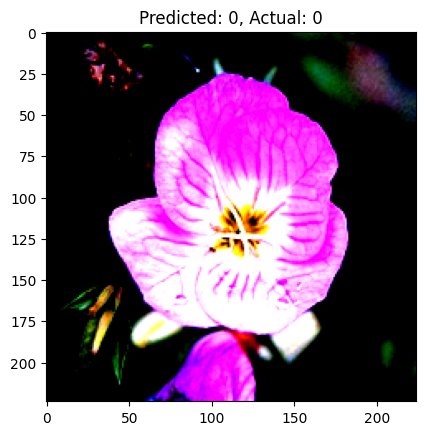

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.0648367].


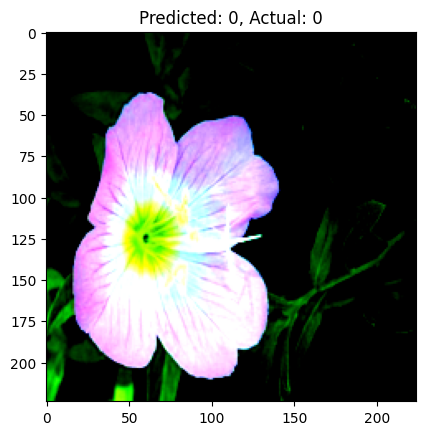

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


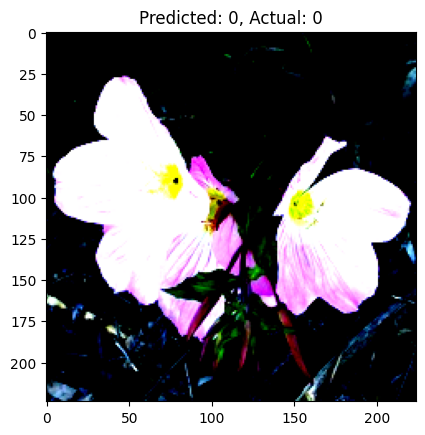

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.843908..2.6051416].


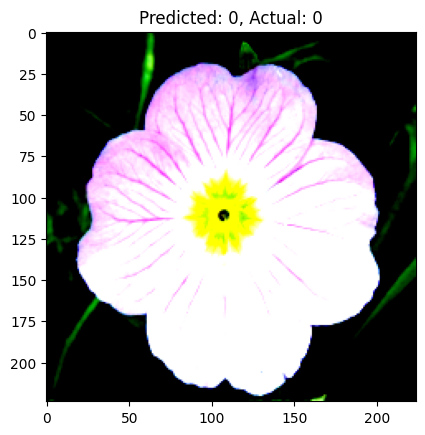

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


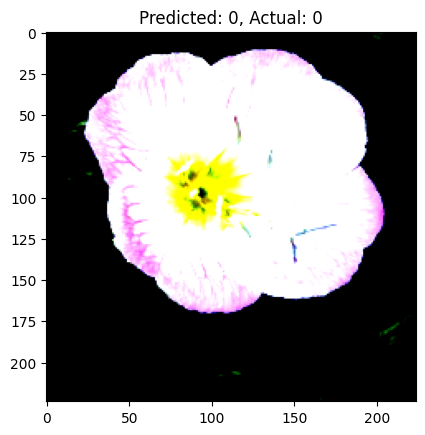

In [19]:
import matplotlib.pyplot as plt

def visualize_predictions(model, dataloader, num_images=5):
    model.eval()
    images_shown = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for i in range(inputs.size(0)):
                if images_shown == num_images:
                    return
                plt.imshow(inputs[i].cpu().permute(1, 2, 0).numpy())
                plt.title(f'Predicted: {preds[i].item()}, Actual: {labels[i].item()}')
                plt.show()
                images_shown += 1

visualize_predictions(model, test_loader, num_images=5)
